# Conformal Predictions for Weather Image Classification

Statistical Learning 2022 - Final Project 
Group 12
* Davide Cacciatore
* Luca Mattei
* Luca Romani

### Import Libraries

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import tensorflow as tf
import keras
import glob
from google.colab import drive

# Import from sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Import from keras
from keras import callbacks
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Add, Input, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount the drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SL Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SL Project


### Loading the dataset

In [3]:
# Set the size of the loaded images
SIZE = 256

# Set the sizes of the plots
plt.rcParams["figure.figsize"] = (20,8)

In [ ]:
# Load the dataset and save it into a npy file
'''
dataset = []
label = [] 
for directory_path in glob.glob("Data/*"):
    label_ = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
            img = cv2.resize(img, (SIZE, SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            dataset.append(img)
            label.append(label_)
        except Exception as e:
            print(str(e))

# Store dataset        
dataset = np.array(dataset)
label = np.array(label)

# Save dataset
np.save('dataset.npy', dataset)
np.save('label.npy', label)
'''

In [4]:
# Load the dataset from the npy file
dataset = np.load('Data/dataset.npy')
label = np.load('Data/label.npy')

In [7]:
# Load the test data
test = [] 
for img_path in glob.glob("Test/*.jpg"):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test.append(img)
    except Exception as e:
        print(str(e))

# Store dataset        
test = np.array(test)

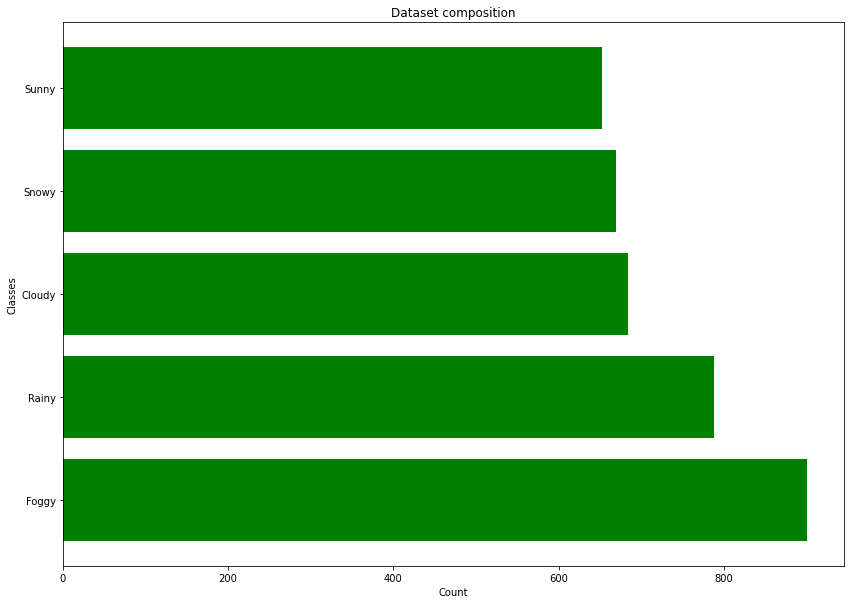

In [6]:
# Plot the dataset composition

# Figure size
plt.figure(figsize=[14, 10])

# Plot
plt.barh(['Foggy', 'Rainy', 'Cloudy', 'Snowy', 'Sunny'], [900, 788, 684, 670, 652], color = 'green')
plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('Dataset composition')

# Saving the plot as a 'png'
plt.savefig('Img/BarPlot.png')
plt.show()

### Some Useful Functions

In [9]:
# Function to print an image

def print_image(image):
    # if the image is rgb
    if len(image.shape) == 3:
        imgplot = plt.imshow(image)
    # if the image is bw
    else:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [10]:
# Function to convert a colored image to a black & white image

def rgb2gray(rgb):
    '''
    RGB -> gray_scale
    '''
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [11]:
# Function to print the confusion matrix in a formatted way

def conf_mat(y_test, y_model):
    mat = confusion_matrix(y_test, y_model)
    ax = plt.subplot()
    sns.heatmap(mat, annot=True, cmap='Blues', fmt='g', square=True)
    ax.xaxis.set_ticklabels(['cloudy', 'foggy', 'rainy', 'snowy', 'sunny'])
    ax.yaxis.set_ticklabels(['cloudy', 'foggy', 'rainy', 'snowy', 'sunny'])
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()

#### Adaptive Conformal Prediction

With the conformal predictions we perform a set of predictions instead of point prediction with some statistical guarantees. 

Our aim is that $\Pr(\text{Correct Prediction in the Set}) \ge 1−\alpha$. The prediction sets should be as small as possible and they should be adaptive, it means that the harder the example is the larger the set should be.

We took the sum (in order of likelihood) of all the estimated probabilities up until the true class. It represents the amount of estimated probability required to obtain the true class. It can be expressed as follows:

$$
\sum_{j=1}^k \hat{f}(X)_{\pi_j}
$$

where $\hat{f}(X)$ represents the probabilities and $\pi_j$ is the j-th permutation of $\{1,...,k\}$ that sorts them.

At this point, we can estimate the quantile on the calibration data:

$$
\hat{q}:=\frac{\lceil(n+1)(1-\alpha)\rceil}{n}
$$

In [12]:
def lambda_conf(output, label, alpha = 0.05):
    '''
    output <- estimated probabilities to belong to each class
    label <- true labels
    '''
    # Desired quantile
    correction = ((output.shape[0]+1)*(1-alpha))/output.shape[0]
    scores = []
    
    for i in range(output.shape[0]):
        # Amount of estimated probability required to obtain the true class
        idx = int(np.where(np.argsort(output[i,])[::-1] == int(label[i]))[0])
        scores.append(sum(np.sort(output[i,])[::-1][:idx]))

    # Get the quantile of the scores
    lambda_conformal = np.quantile(scores, correction, interpolation='lower')
    return(lambda_conformal)

Then, we perform estimations by taking the $k$ most likely classes such the amount of estimated probability required to obtain the true class is greater or equal than the quantile.

$$
k=\inf\{k:\sum_{j=1}^k \hat{f}(X)_{\pi_j}\ge \hat{q}\}
$$

In [13]:
def ad_conf_pred(output, lambda_conformal, label = None):
    '''
    output <- estimated probabilities to belong to each class
    lambda_conformal <- quantile of the scores
    label <- true classes (if present it will compute also the coverage)
    '''    
    pred_aps = []     # conformal sets
    coverage = 0      # coverage (only if label = True)
    size_aps = []     # size of the sets

    for i in range(output.shape[0]):
        # Find the amount of estimated probability required to obtain that 
        # the true class is greater or equal than the quantile
        indices = np.where(np.cumsum(np.sort(output[i,])[::-1]) > lambda_conformal)[0][0]
        # Build the conformal set in descending order from the most likely class
        # to the least likely
        conformal_set = np.argsort(output[i,])[::-1][:indices+1].tolist()
        pred_aps.append(le.inverse_transform(conformal_set))

        # If there is a ground truth compute the coverage
        if label is not None: coverage += True if int(label[i]) in conformal_set else False

        # Size of the sets
        size_aps.append(len(conformal_set))

    # Get a relative quantity of the coverage
    coverage = np.round(coverage/output.shape[0], 3)
    
    return(pred_aps, coverage, size_aps)

### Data preparation and visualization


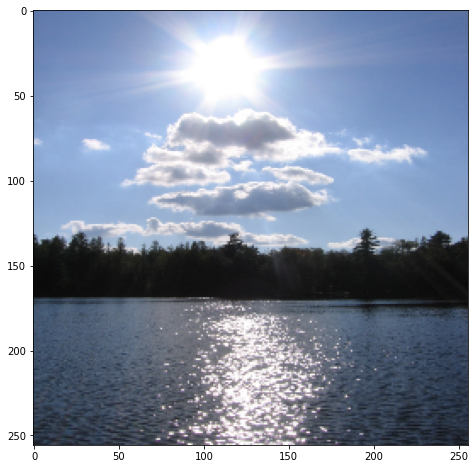

Sunny


In [ ]:
# Print the original image
i = 3421
print_image(dataset[i])
print(label[i])

We created a copy of the original dataset where we applied a *Gaussian blur* filter on the images. This is a widely used technique in image pre-processing in particular when reducing the size of an image. This way we smooth the image and we remove details and noise.

In [ ]:
# Apply a Gaussian filter to the dataset to remove noise
blur_dataset = []
for img in dataset:
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    blur_dataset.append(blurred_img)

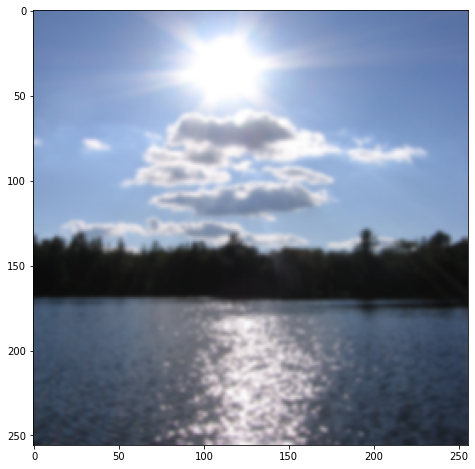

'Sunny'

In [ ]:
# Print the blurred image
i = 3421
print_image(blur_dataset[i])
label[i]

All the methods we know cannot deal with 3D matrices, so we had to transform our images in a gray scale format.

In [ ]:
# Create a black & white version of the blurred dataset
blur_bw_dataset = []
for img in blur_dataset:
    blur_bw_dataset.append(rgb2gray(img))

In [ ]:
# Create a black & white version of the original dataset
bw_dataset = []
for img in dataset:
    bw_dataset.append(rgb2gray(img))

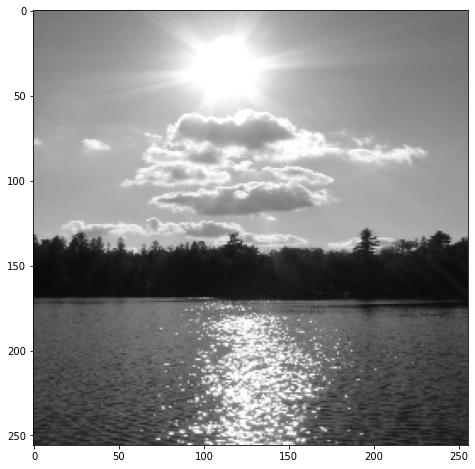

Sunny


In [ ]:
# Print the black & white image
i = 3421
print_image(bw_dataset[i])
print(label[i])

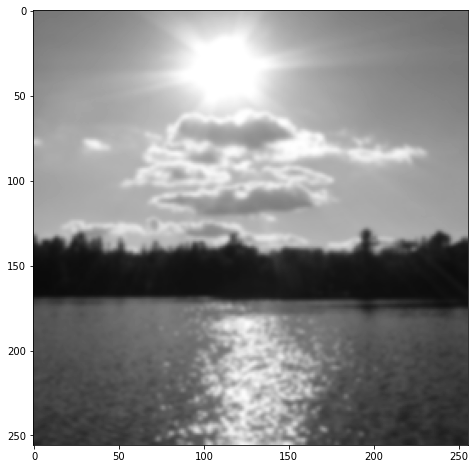

Sunny


In [ ]:
# Print the blurred black & white image
i = 3421
print_image(blur_bw_dataset[i])
print(label[i])

Flatten the array into one dimension.

In [ ]:
# Flatten the bw_dataset
flat_bw_dataset = []
for el in bw_dataset:
    flat_bw_dataset.append(el.flatten())

In [ ]:
# Flatten the blur_bw_dataset
flat_blur_bw_dataset = []
for el in blur_bw_dataset:
    flat_blur_bw_dataset.append(el.flatten())

### Models

We splitted our dataset into train and validation test, setting the validation size equal to
the 33% of the dataset. We decided to use classical classification methods on our data such as
*Gaussian Naive Bayes*, *Random Forest*, *Logistic Regression* and *Support Vector Machines*.

The **Random Forest** model was the best in terms of accuracy and F1 score. We can notice how we
can obtain better results with the non-blurred dataset, so we decided to keep it in the next steps
of the analysis.

#### Splitting the data

In [ ]:
# Split of the bw_dataset
X_train, X_test, y_train, y_test = train_test_split(flat_bw_dataset, label, test_size = 0.33, random_state = 69420)

In [ ]:
# Split of the blurred bw_dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(flat_blur_bw_dataset, label, test_size = 0.33, random_state = 69420)

#### GaussianNB

Naive Bayes methods are a set of supervised learning algorithms based
on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. In the Gaussian Naive Bayes algorithm for
classification the likelihood of the features is assumed to be Gaussian. Due to this strong assumptions we did not expect good results with this model, that is rarely used for image classification.
We did not specify any prior probabilities, the algorithm will calculate them directly from data.

In [ ]:
# Gaussian NB model on the bw dataset
model = GaussianNB()
model.fit(X_train, y_train)
y_model = model.predict(X_test)

# Gaussian NB model on the blurred bw dataset
model1 = GaussianNB()
model1.fit(X_train1, y_train1)
y_model1 = model1.predict(X_test1)

# Print the metrics
print(f'Accuracy score for the model: {accuracy_score(y_test, y_model)}')
print(f'F1 score for the model: {f1_score(y_test, y_model, average = "macro")}')
print(f'Accuracy score for the model with Gaussian blur: {accuracy_score(y_test1, y_model1)}')
print(f'F1 score for the model with Gaussian blur: {f1_score(y_test1, y_model1, average = "macro")}')

Accuracy score for the model: 0.5647540983606557
F1 score for the model: 0.556223217824235
Accuracy score for the model with Gaussian blur: 0.5516393442622951
F1 score for the model with Gaussian blur: 0.5410833878177161


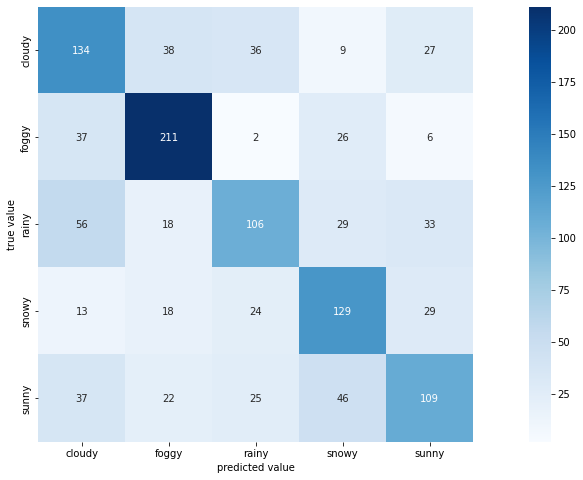

In [ ]:
# Confusion matrix 
conf_mat(y_test, y_model)

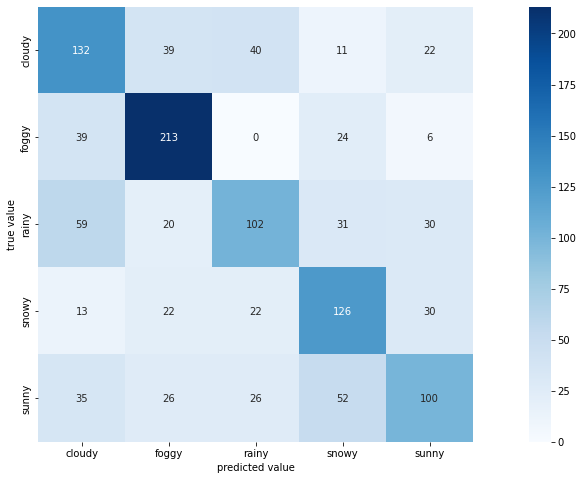

In [ ]:
# Confusion matrix (Gaussian blur)
conf_mat(y_test1, y_model1)

#### SVM

Support Vector Machines (SVMs) are a set of supervised learning
methods capable of performing binary and multi-class classification on a dataset. We decided to
use a linear kernel which resulted to be the best in terms of accuracy compared with the other
kernels.

In [ ]:
#### HIGH RAM CONSUMING ####

# Linear SVM model on the bw dataset
model = SVC(kernel = 'linear', gamma = 'auto')
model.fit(X_train, y_train)
y_model = model.predict(X_test)

# Linear SVM model on the blurred bw dataset
model1 = SVC(kernel = 'linear', gamma = 'auto')
model1.fit(X_train1, y_train1)
y_model1 = model1.predict(X_test1)

# Print the metrics
print(f'Accuracy score for the model: {accuracy_score(y_test, y_model)}')
print(f'F1 score for the model: {f1_score(y_test, y_model, average = "macro")}')
print(f'Accuracy score for the model with Gaussian blur: {accuracy_score(y_test1, y_model1)}')
print(f'F1 score for the model with Gaussian blur: {f1_score(y_test1, y_model1, average = "macro")}')

Accuracy score for the model: 0.6426229508196721
F1 score for the model: 0.6086474747472449
Accuracy score for the model with Gaussian blur: 0.6336065573770492
F1 score for the model with Gaussian blur: 0.6042369649591961


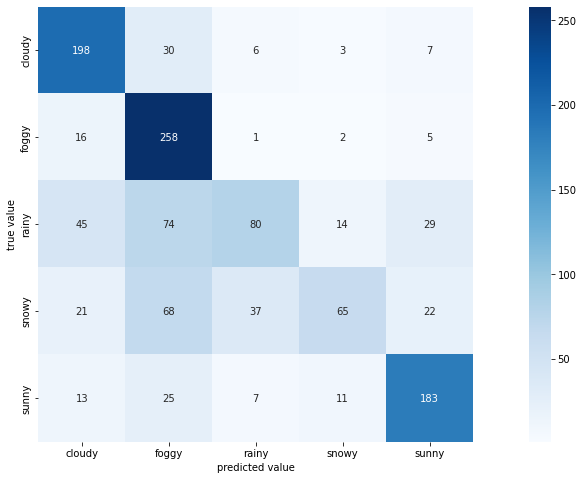

In [ ]:
# Confusion matrix
conf_mat(y_test, y_model)

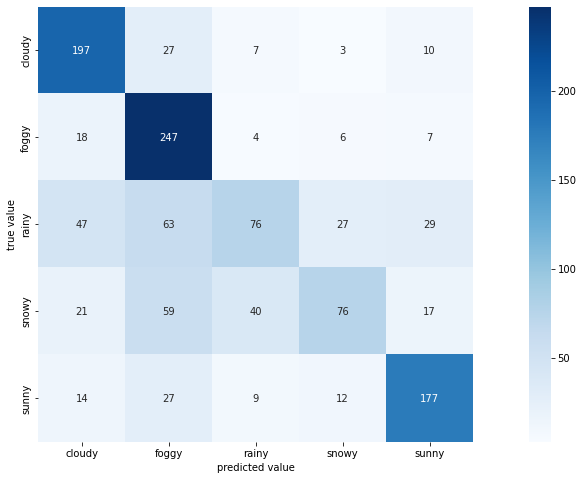

In [ ]:
# Confusion matrix (Gaussian blur)
conf_mat(y_test1, y_model1)

#### Random forest

The Random Forest classifier fits a number of decision tree classifiers on various
sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-
fitting. In this analysis, we kept the number of decision trees equal to 50.

In [ ]:
# Random Forest for the bw dataset
model = RandomForestClassifier(n_estimators = 50, random_state = 42)
model.fit(X_train, y_train)
y_model = model.predict(X_test)

# Random forest for the blurred bw dataset
model1 = RandomForestClassifier(n_estimators = 50, random_state = 42)
model1.fit(X_train1, y_train1)
y_model1 = model1.predict(X_test1)

# Print the metrics
print(f'Accuracy score for the model: {accuracy_score(y_test, y_model)}')
print(f'F1 score for the model: {f1_score(y_test, y_model, average = "macro")}')
print(f'Accuracy score for the model with Gaussian blur: {accuracy_score(y_test1, y_model1)}')
print(f'F1 score for the model with Gaussian blur: {f1_score(y_test1, y_model1, average = "macro")}')

Accuracy score for the model: 0.771311475409836
F1 score for the model: 0.7653927550826031
Accuracy score for the model with Gaussian blur: 0.760655737704918
F1 score for the model with Gaussian blur: 0.7529723051381805


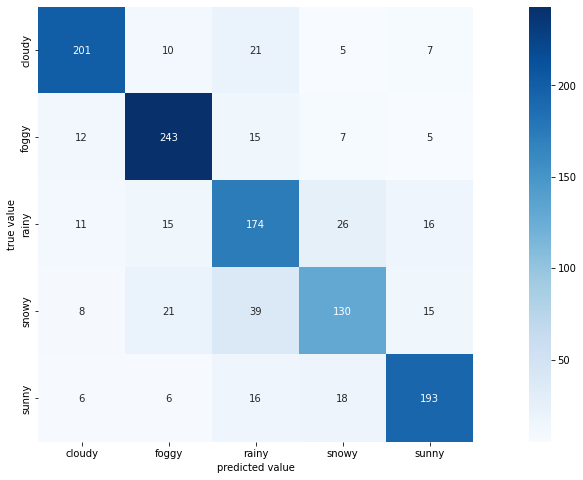

In [ ]:
# Confusion matrix
conf_mat(y_test, y_model)

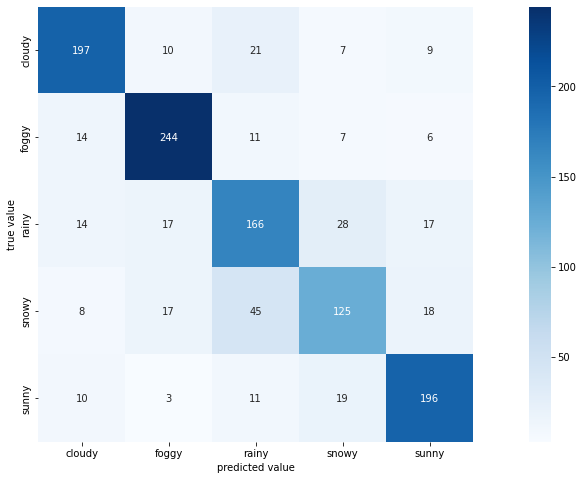

In [ ]:
# Confusion matrix (Gaussian blur)
conf_mat(y_test1, y_model1)

#### Logistic Regression

Logistic Regression, despite its name, is a linear model for classification
rather than regression. We used as solver the *‘newton-cg’* which supports $l2$ regularization, it is
used for the multinomial models and it was found to converge faster for high-dimensional data.
We setted 1000 maximum iterations for the algorithm to ensure the convergence.

In [ ]:
# Logistic Regression for the bw dataset
model = LogisticRegression(solver = 'newton-cg', random_state = 42, 
                           max_iter = 1000, multi_class = 'multinomial')
model.fit(X_train, y_train)
y_model = model.predict(X_test)

# Logistic Regression for the blurred bw dataset
model1 = LogisticRegression(solver = 'newton-cg', random_state = 42, 
                            max_iter = 1000, multi_class = 'multinomial')
model1.fit(X_train1, y_train1)
y_model1 = model1.predict(X_test1)

# Print the metrics
print(f'Accuracy score for the model: {accuracy_score(y_test, y_model)}')
print(f'F1 score for the model: {f1_score(y_test, y_model, average = "macro")}')
print(f'Accuracy score for the model with Gaussian blur: {accuracy_score(y_test1, y_model1)}')
print(f'F1 score for the model with Gaussian blur: {f1_score(y_test1, y_model1, average = "macro")}')

Accuracy score for the model: 0.5967213114754099
F1 score for the model: 0.5536346991011374
Accuracy score for the model with Gaussian blur: 0.580327868852459
F1 score for the model with Gaussian blur: 0.5414081807685653


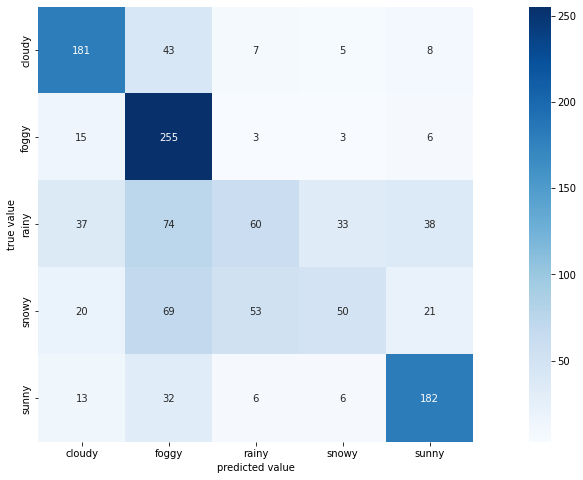

In [ ]:
# Confusion matrix
conf_mat(y_test, y_model)

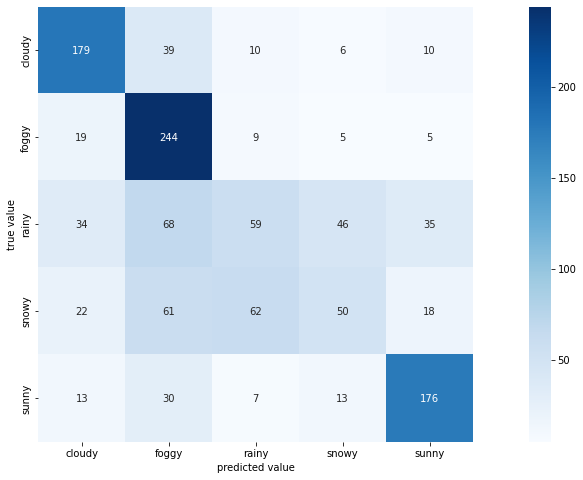

In [ ]:
# Confusion matrix (Gaussian blur)
conf_mat(y_test1, y_model1)

### CNN

-- From now on: **GPU** --

In [14]:
# Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(label)
train_labels_encoded = le.transform(label)

In [15]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(dataset, train_labels_encoded, test_size=0.33, random_state=69420)

In [16]:
# One-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [17]:
# Initialize the CNN model
model = Sequential()
initializer = keras.initializers.he_uniform(seed=200)

chanDim = 1

#BLOCK 1
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape=(SIZE, SIZE, 3), kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))

#BLOCK 2
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 3
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 4 
model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', kernel_initializer=initializer))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Classifier
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu", kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu", kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

In [18]:
# Set the epochs and the batch size
epochs = 100
batch_size = 16

In [19]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     1024      
 hNormalization)                                        

In [20]:
# Optimizer
opt = Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Defining Callbacks
def myCallbacks():
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, 
                                            patience=5, min_lr=1e-30, cooldown=3, verbose=1)
    return [reduce_lr]

In [22]:
# Fit the model
'''
history = model.fit(X_train, y_train_one_hot, epochs=epochs, 
                    validation_data = (X_test, y_test_one_hot), callbacks = myCallbacks())
'''

'\nhistory = model.fit(X_train, y_train_one_hot, epochs=epochs, \n                    validation_data = (X_test, y_test_one_hot), callbacks = myCallbacks())\n'

In [101]:
# Load the model
model = load_model("Models/data2_cnn.h5")

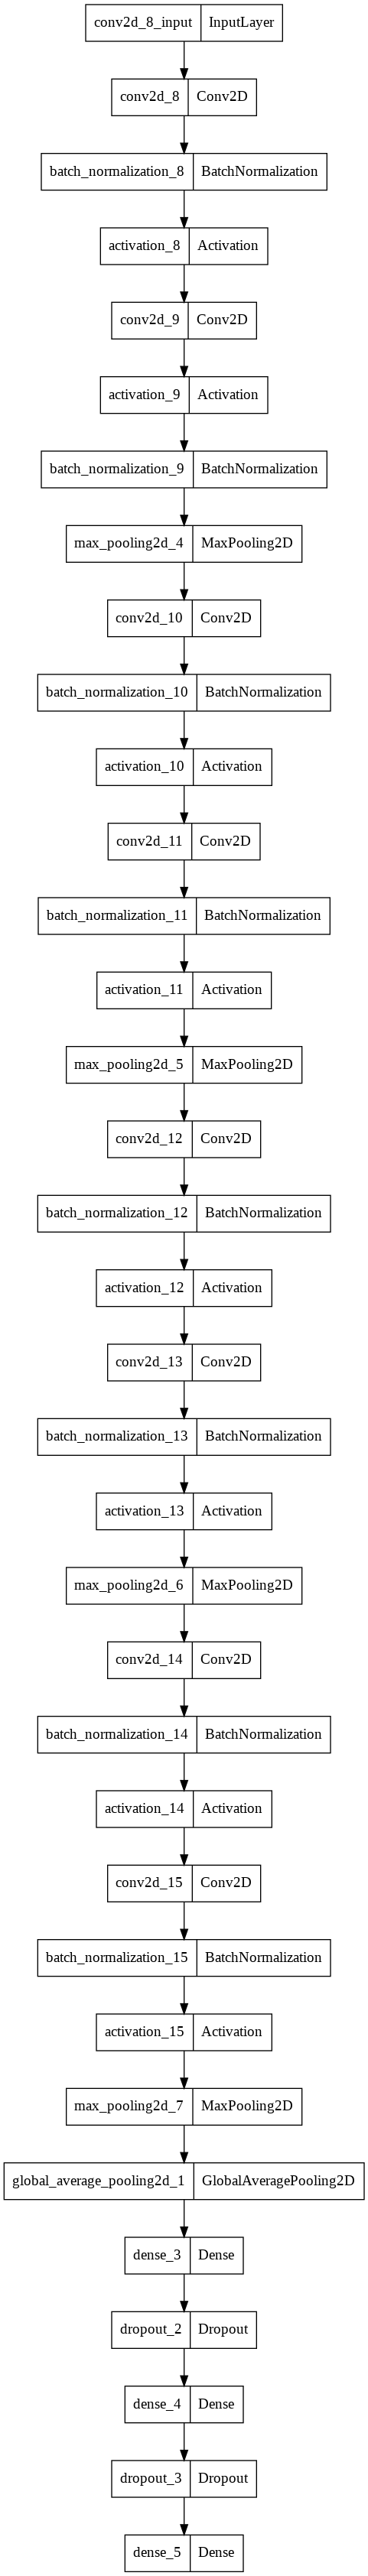

In [24]:
# Visualize the model structure
plot_model(model, to_file='model.png')

In [25]:
# Take the prediction on the test set
prob = model.predict(X_test)
prediction = np.argmax(prob, axis=-1)

In [26]:
# Print the metrics
print(f'Accuracy score for the model: {accuracy_score(y_test, prediction)}')
print(f'F1 score for the model: {f1_score(y_test, prediction, average = "macro")}')

Accuracy score for the model: 0.8442622950819673
F1 score for the model: 0.8413000726426338


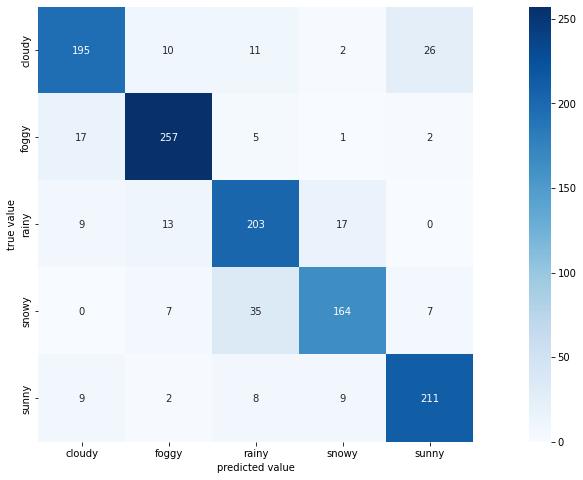

In [27]:
# Confusion matrix
conf_mat(y_test, prediction)

In [28]:
# Save the model
#model.save("data2_cnn.h5")

#### Adaptive Conformal Predictions

In [29]:
# Evaluate the quantile
lambda_c = lambda_conf(prob, y_test)
lambda_c

0.8753575831651688

In [30]:
# Conformal predictions
conformal_pred, coverage, size_aps = ad_conf_pred(prob, lambda_c, label = y_test)

In [31]:
# See the coverage
print(coverage)

0.95


In [32]:
# See the size of the predictions
#print(size_aps)

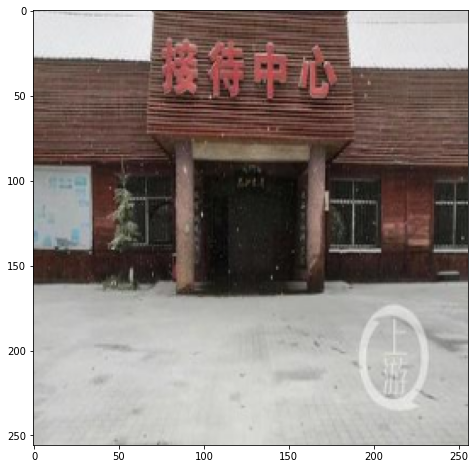

Ground truth:  Snowy
Conformal predictions:  ['Rainy' 'Snowy']


In [33]:
# Try some images
i = 10
print_image(X_test[i])
print('Ground truth: ', le.inverse_transform(y_test)[i])
print('Conformal predictions: ', conformal_pred[i])

### Models on CNN extracted features

#### CNN feature extractor

In [34]:
# Initialize the CNN feature extractor
feature_extractor = Sequential()
initializer=keras.initializers.he_uniform(seed=200)

chanDim = 1

#BLOCK 1
feature_extractor.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (256, 256, 3), kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(Activation("relu"))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(MaxPooling2D(pool_size=(2,2)))

#BLOCK 2
feature_extractor.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 3
feature_extractor.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 4 
feature_extractor.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', kernel_initializer=initializer))
feature_extractor.add(BatchNormalization(axis=chanDim))
feature_extractor.add(Activation("relu"))
feature_extractor.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Flatten the features
feature_extractor.add(Flatten())

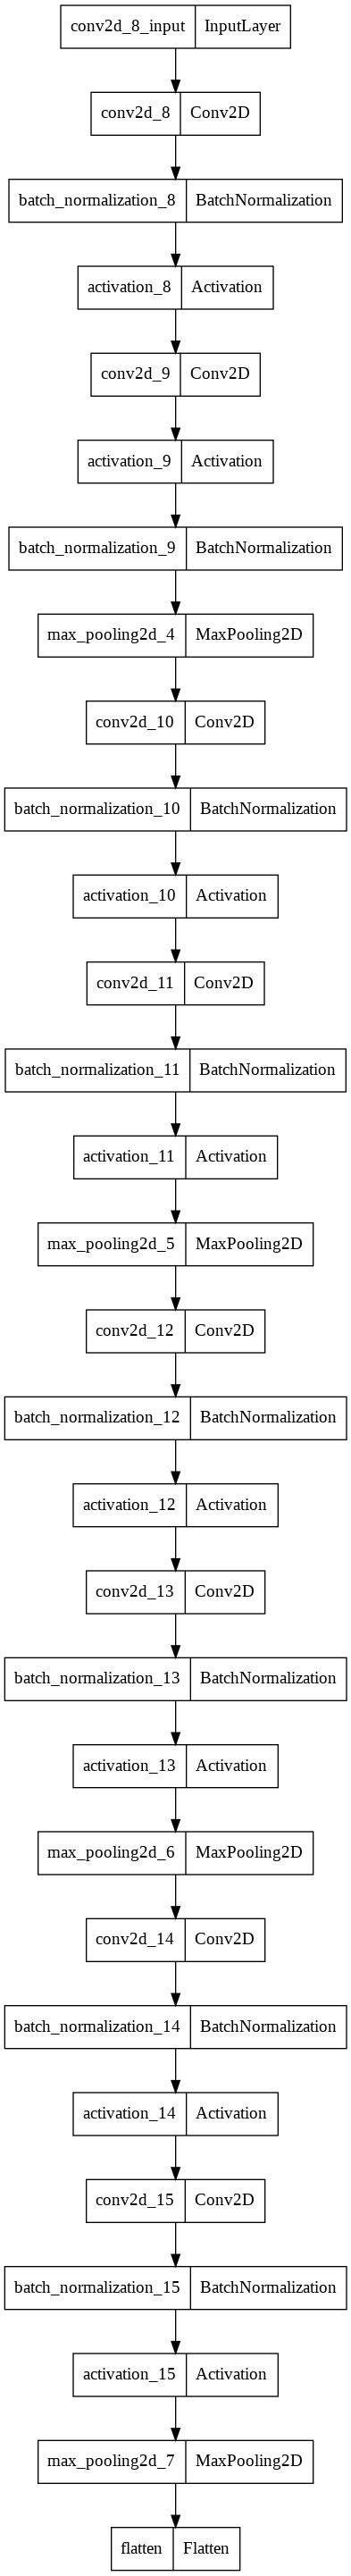

In [35]:
# Visualize the model structure
plot_model(feature_extractor, to_file = 'feature_extractor.png')

In [36]:
# Extract the feature on the train set
X = feature_extractor.predict(X_train) 

In [37]:
X.shape

(2474, 65536)

In [38]:
# Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(X_test)

#### Random forest

In [39]:
# Random Forest
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X, y_train)
prediction_RF = RF_model.predict(X_test_feature)

Accuracy:  0.8418032786885246
F1 score: 0.837405494357753


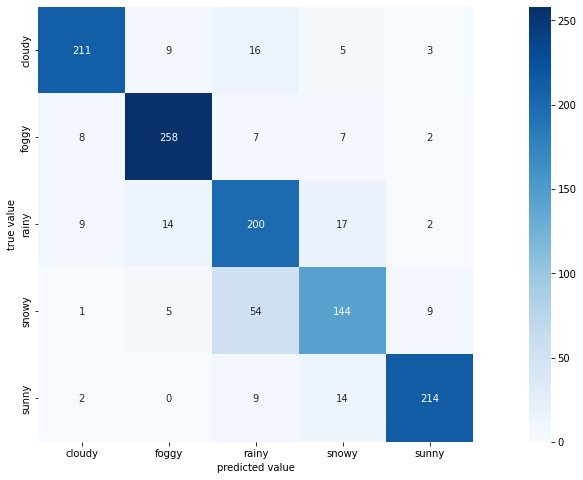

In [40]:
# Print overall metrics and confusion matrix
print ("Accuracy: ", accuracy_score(y_test, prediction_RF))
print(f'F1 score: {f1_score(y_test, prediction_RF, average = "macro")}')
conf_mat(y_test, prediction_RF)

##### RF - Adaptive Conformal Predictions

In [41]:
# Get the probabilities for each class
prob_RF = RF_model.predict_proba(X_test_feature)

In [42]:
# Compute the quantile
lambda_c_RF = lambda_conf(prob_RF, y_test)
lambda_c_RF

0.72

In [43]:
# Compute conformal predictions
conformal_pred_RF, coverage_RF, size_aps_RF = ad_conf_pred(prob_RF, lambda_c_RF, label = y_test)

In [44]:
# See the coverage
print(coverage_RF)

0.953


In [45]:
#print(size_aps_RF)

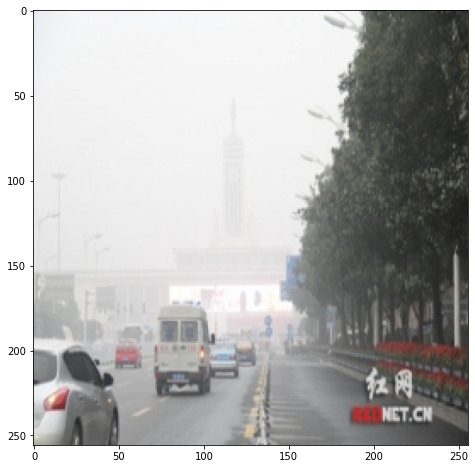

Ground truth:  Foggy
Conformal predictions:  ['Snowy' 'Rainy' 'Foggy']


In [46]:
# Try some images
i = 46
print_image(X_test[i])
print('Ground truth: ', le.inverse_transform(y_test)[i])
print('Conformal predictions: ', conformal_pred_RF[i])

##### PCA

In [47]:
# PCA on the CNN extracted feature
pca = PCA()
pca.fit(X)

PCA()

In [48]:
print(sum(pca.explained_variance_ratio_[0:40]))

0.802783201332204


In [49]:
pca_X = pca.transform(X)
pca_X = pca_X[:, :40]

In [50]:
pca_X_test = pca.transform(X_test_feature)
pca_X_test = pca_X_test[:, :40]

In [51]:
# Random Forest
RF_model_pca = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model_pca.fit(pca_X, y_train)
prediction_RF_pca = RF_model_pca.predict(pca_X_test)

Accuracy:  0.8139344262295082
F1 score: 0.8108353822936933


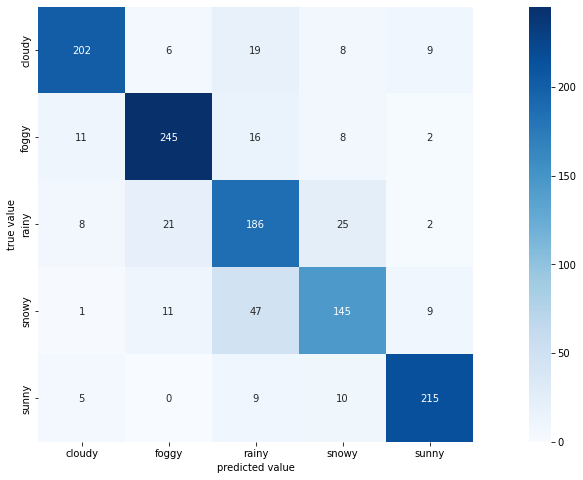

In [52]:
# Print overall metrics and confusion matrix
print("Accuracy: ", accuracy_score(y_test, prediction_RF_pca))
print(f'F1 score: {f1_score(y_test, prediction_RF_pca, average = "macro")}')
conf_mat(y_test, prediction_RF_pca)

#### SVM

In [53]:
# Linear SVM
SVM_model = SVC(kernel = 'linear', gamma = 'auto', probability = True)
SVM_model.fit(X, y_train)
prediction_SVM = SVM_model.predict(X_test_feature)

Accuracy:  0.8336065573770491
F1 score: 0.8295846211498834


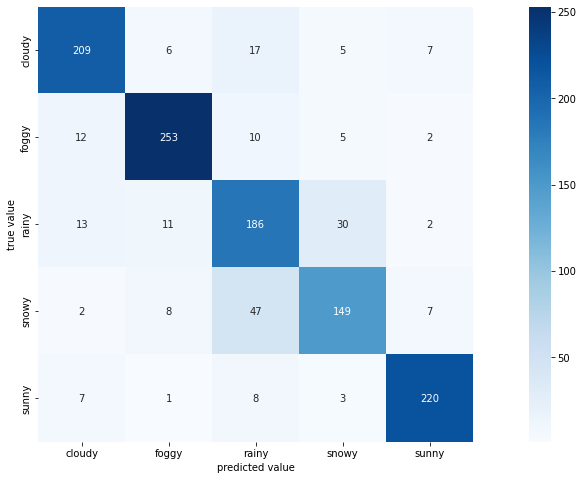

In [54]:
# Print metrics and confusion matrix
print("Accuracy: ", accuracy_score(y_test, prediction_SVM))
print(f'F1 score: {f1_score(y_test, prediction_SVM, average = "macro")}')
conf_mat(y_test, prediction_SVM)

##### SVM - Adaptive Conformal Predictions

In [55]:
# Get the probabilities of each class
prob_SVM = SVM_model.predict_proba(X_test_feature)

In [56]:
# Compute the quantile
lambda_c_SVM = lambda_conf(prob_SVM, y_test)
lambda_c_SVM

0.8261820211422614

In [57]:
# Compute conformal predictions
conformal_pred_SVM, coverage_SVM, size_aps_SVM = ad_conf_pred(prob_SVM, lambda_c_SVM, label = y_test)

In [58]:
# See the coverage
print(coverage_SVM)

0.95


In [59]:
#print(size_aps_SVM)

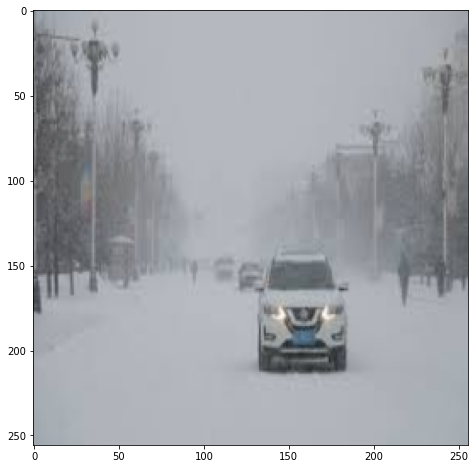

Ground truth:  Snowy
Conformal predictions:  ['Snowy' 'Foggy' 'Rainy']


In [60]:
# Try some images
i = 150
print_image(X_test[i])
print('Ground truth: ', le.inverse_transform(y_test)[i])
print('Conformal predictions: ', conformal_pred_SVM[i])

#### GaussianNB

In [61]:
# Gaussian Naive Bayes
GNB_model = GaussianNB()
GNB_model.fit(X, y_train)
prediction_GNB = GNB_model.predict(X_test_feature)

Accuracy:  0.6409836065573771
F1 score: 0.6264836266153881


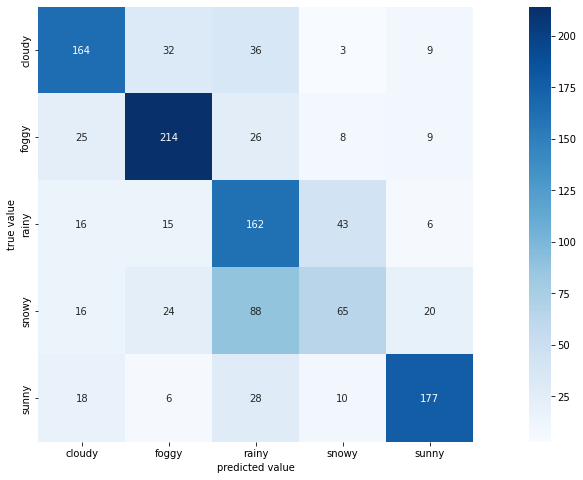

In [62]:
# Print metrics and conformal prediction
print("Accuracy: ", accuracy_score(y_test, prediction_GNB))
print(f'F1 score: {f1_score(y_test, prediction_GNB, average = "macro")}')
conf_mat(y_test, prediction_GNB)

##### GNB - Adaptive Conformal Predictions

In [63]:
# Get the probabilities for each class
prob_GNB = GNB_model.predict_proba(X_test_feature)

In [64]:
# Compute the quantile
lambda_c_GNB = lambda_conf(prob_GNB, y_test)
lambda_c_GNB

1.0

In [65]:
print(prob_GNB)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


#### Logistic Regression

In [66]:
# Logistic Regression
LR_model = LogisticRegression(solver = 'newton-cg', random_state = 42, max_iter = 1000)
LR_model.fit(X, y_train)
prediction_LR = LR_model.predict(X_test_feature)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy:  0.8204918032786885
F1 score: 0.8130714741056504


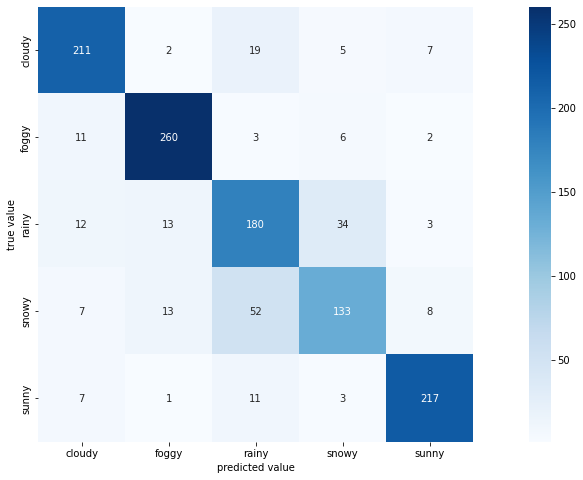

In [67]:
# Print metrics and confusion matrix
print("Accuracy: ", accuracy_score(y_test, prediction_LR))
print(f'F1 score: {f1_score(y_test, prediction_LR, average = "macro")}')
conf_mat(y_test, prediction_LR)

##### LR - Adaptive Conformal Predictions

In [68]:
# Get the probabilities for each class
prob_LR = LR_model.predict_proba(X_test_feature)

In [69]:
# Compute the quantile
lambda_c_LR = lambda_conf(prob_LR, y_test)
lambda_c_LR

0.9998593446798623

In [70]:
# Compute conformal predictions
conformal_pred_LR, coverage_LR, size_aps_LR = ad_conf_pred(prob_LR, lambda_c_LR, label = y_test)

In [71]:
# See the coverage
print(coverage_LR)

0.95


In [72]:
#print(size_aps_LR)

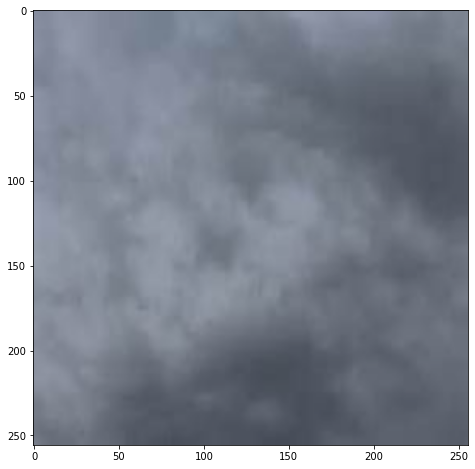

Ground truth:  Cloudy
Conformal predictions:  ['Cloudy' 'Foggy']


In [73]:
# Try some images
i = 4
print_image(X_test[i])
print('Ground truth: ', le.inverse_transform(y_test)[i])
print('Conformal predictions: ', conformal_pred_LR[i])

### EfficientNetB4

This model is part of a class of pre-trained models introduced by Google AI, in particular it is pre-trained on ImageNet and then applied to the images in our train set.

In [74]:
# Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(label)
train_labels_encoded = le.transform(label)

In [75]:
# Defining Callbacks
def myCallbacks():
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, 
                                            patience=5, min_lr=1e-30, cooldown=3, verbose=1)
    return [reduce_lr]

In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(dataset, train_labels_encoded, test_size=0.33, random_state = 69420)

In [77]:
# One hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [78]:
# Initialize the EfficientNetB4 model
model_name='EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",
                                                  input_shape=(SIZE,SIZE,3), pooling='max') 
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output = Dense(5, activation='softmax')(x)
model_EN = Model(inputs=base_model.input, outputs=output)
model_EN.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set the epochs
epochs = 40

In [79]:
# Run the model
'''
history = model.fit(X_train, y_train_one_hot, epochs=epochs, 
                    validation_data = (X_test, y_test_one_hot), callbacks = myCallbacks())
'''

'\nhistory = model.fit(X_train, y_train_one_hot, epochs=epochs, \n                    validation_data = (X_test, y_test_one_hot), callbacks = myCallbacks())\n'

In [80]:
# Save model and architecture to single file
#model.save("Models/enb4_model.h5")

In [81]:
# Load the model
model_EN = load_model('Models/enb4_model.h5')

In [82]:
# Get predictions on test set
prob_EN = model_EN.predict(X_test)
prediction = np.argmax(prob_EN, axis=-1)

Accuracy: 0.9647540983606557
F1 score: 0.9642701129286382


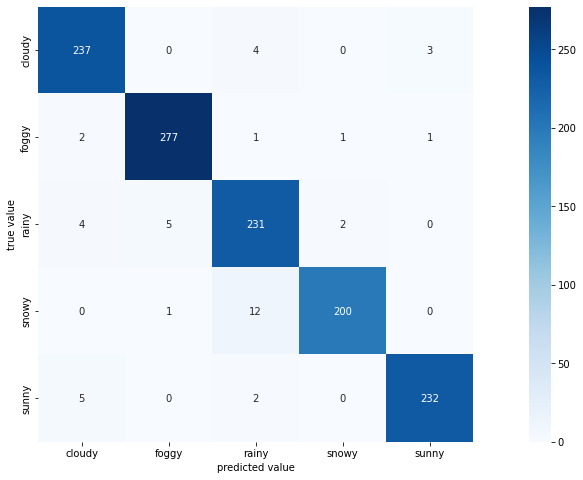

In [83]:
# Print metrics and confusion matrix
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1 score: {f1_score(y_test, prediction, average = "macro")}')
conf_mat(y_test, prediction)

#### ENB4 - Adaptive Conformal Predictions

In [84]:
# Compute the quantile
lambda_c_EN = lambda_conf(prob_EN, y_test, alpha = 0.005)

In [85]:
lambda_c_EN

0.9842360019683838

In [86]:
# Compute conformal predictions
conformal_pred_EN, coverage_EN, size_aps_EN = ad_conf_pred(prob_EN, lambda_c_EN, label = y_test)

In [87]:
# Coverage
print(coverage_EN)

0.995


In [88]:
#print(size_aps_EN)

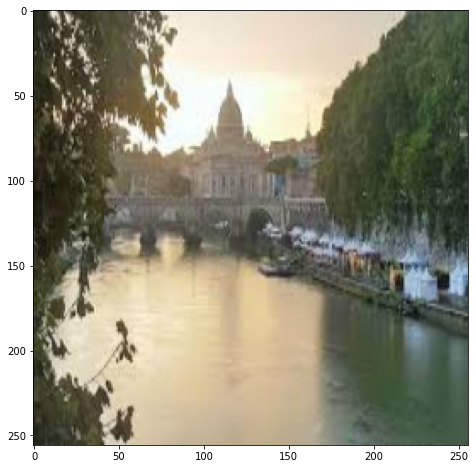

Ground truth:  Rainy
Conformal predictions:  ['Rainy']


In [89]:
# Try some images
i = 1218
print_image(X_test[i])
print('Ground truth: ', le.inverse_transform(y_test)[i])
print('Conformal predictions: ', conformal_pred_EN[i])

### Test

In [97]:
def all_preds(img):

    # Print the image
    print_image(img)

    # CNN predictions
    cnn_pred = model.predict(np.array([img]))
    print()
    print('CNN prediction: ', *le.inverse_transform(np.argmax(cnn_pred, axis=-1)))
    conformal_pred_CNN = ad_conf_pred(cnn_pred, lambda_c)[0]
    print('CNN Conformal predictions: ', *conformal_pred_CNN[0])

    # Feature extractor
    feature = feature_extractor.predict(np.array([img]))

    # Random Forest predictions
    RF_pred = RF_model.predict_proba(feature)
    print()
    print('RF prediction: ', *le.inverse_transform(np.argmax(RF_pred, axis=-1)))
    conformal_pred_RF = ad_conf_pred(RF_pred, lambda_c_RF)[0]
    print('RF Conformal predictions: ', *conformal_pred_RF[0])

    # SVM predictions
    SVM_pred = SVM_model.predict_proba(feature)
    print()
    print('SVM prediction: ', *le.inverse_transform(np.argmax(SVM_pred, axis=-1)))
    conformal_pred_SVM = ad_conf_pred(SVM_pred, lambda_c_SVM)[0]
    print('SVM Conformal predictions: ', *conformal_pred_SVM[0])

    # Logistic Regression predictions
    LR_pred = LR_model.predict_proba(feature)
    print()
    print('LR prediction: ', *le.inverse_transform(np.argmax(LR_pred, axis=-1)))
    conformal_pred_LR = ad_conf_pred(LR_pred, lambda_c_LR)[0]
    print('LR Conformal predictions: ', *conformal_pred_LR[0])

    # EfficientNetB4 predictions
    EN_pred = model_EN.predict(np.array([img]))
    print()
    print('EN prediction: ', *le.inverse_transform(np.argmax(EN_pred, axis=-1)))
    conformal_pred_EN = ad_conf_pred(EN_pred, lambda_c_EN)[0]
    print('EN Conformal predictions: ', *conformal_pred_EN[0])

    # Gaussian NB prediction
    GNB_pred = GNB_model.predict_proba(feature)
    print()
    print('GNB prediction: ', *le.inverse_transform(np.argmax(GNB_pred, axis=-1)))

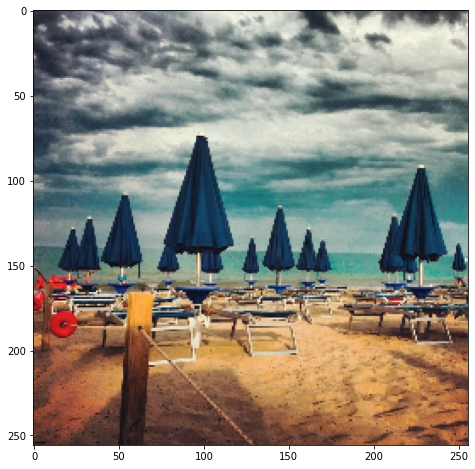


CNN prediction:  Rainy
CNN Conformal predictions:  Rainy

RF prediction:  Rainy
RF Conformal predictions:  Rainy Snowy Cloudy

SVM prediction:  Rainy
SVM Conformal predictions:  Rainy

LR prediction:  Rainy
LR Conformal predictions:  Rainy

EN prediction:  Cloudy
EN Conformal predictions:  Cloudy Snowy Rainy Sunny Foggy

GNB prediction:  Sunny


In [102]:
all_preds(test[15])

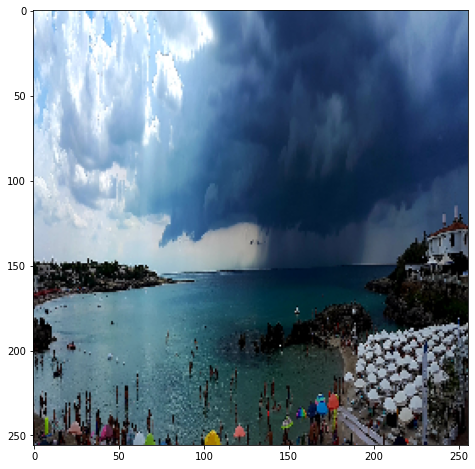


CNN prediction:  Sunny
CNN Conformal predictions:  Sunny Cloudy Snowy Rainy

RF prediction:  Sunny
RF Conformal predictions:  Sunny Rainy Foggy

SVM prediction:  Snowy
SVM Conformal predictions:  Snowy Cloudy Rainy

LR prediction:  Snowy
LR Conformal predictions:  Snowy Rainy Cloudy Sunny

EN prediction:  Cloudy
EN Conformal predictions:  Cloudy Snowy Sunny Foggy Rainy

GNB prediction:  Rainy


In [103]:
all_preds(test[3])

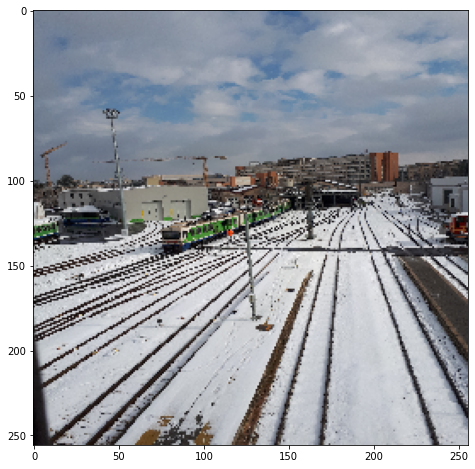


CNN prediction:  Snowy
CNN Conformal predictions:  Snowy

RF prediction:  Snowy
RF Conformal predictions:  Snowy Rainy

SVM prediction:  Snowy
SVM Conformal predictions:  Snowy Rainy

LR prediction:  Snowy
LR Conformal predictions:  Snowy Rainy

EN prediction:  Snowy
EN Conformal predictions:  Snowy

GNB prediction:  Snowy


In [104]:
all_preds(test[2])

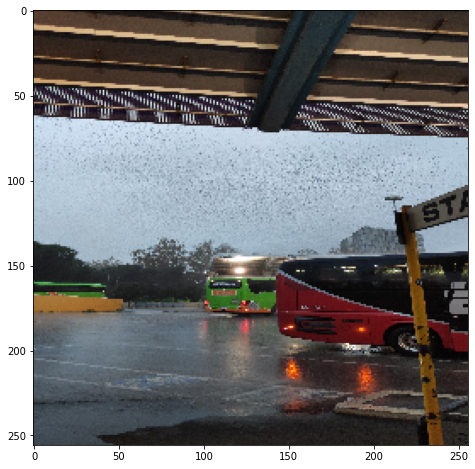


CNN prediction:  Rainy
CNN Conformal predictions:  Rainy

RF prediction:  Rainy
RF Conformal predictions:  Rainy Sunny Cloudy

SVM prediction:  Rainy
SVM Conformal predictions:  Rainy

LR prediction:  Rainy
LR Conformal predictions:  Rainy

EN prediction:  Rainy
EN Conformal predictions:  Rainy Foggy Snowy

GNB prediction:  Rainy


In [105]:
all_preds(test[9])

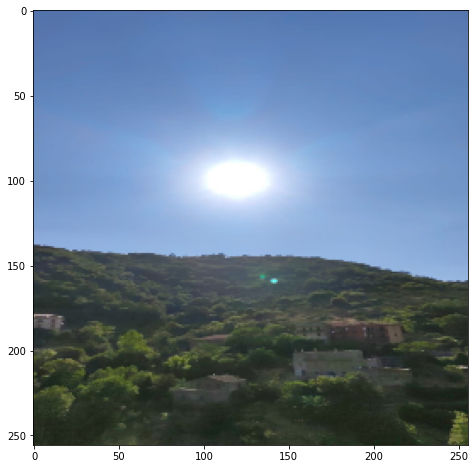


CNN prediction:  Sunny
CNN Conformal predictions:  Sunny Cloudy

RF prediction:  Sunny
RF Conformal predictions:  Sunny Cloudy

SVM prediction:  Sunny
SVM Conformal predictions:  Sunny

LR prediction:  Sunny
LR Conformal predictions:  Sunny Cloudy

EN prediction:  Sunny
EN Conformal predictions:  Sunny Cloudy

GNB prediction:  Sunny


In [106]:
all_preds(test[17])